<a href="https://www.kaggle.com/code/sravanneeli/svm-classifier?scriptVersionId=180200523" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
seed = 143

# 1.0 Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/predicting-pulsar-starintermediate/pulsar_data_train.csv")

df.columns = [col.strip() for col in df.columns]

In [3]:
feature_columns = list(df.drop('target_class', axis=1).columns)
target_columns = ['target_class']

In [4]:
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean of the integrated profile                12528 non-null  float64
 1   Standard deviation of the integrated profile  12528 non-null  float64
 2   Excess kurtosis of the integrated profile     10793 non-null  float64
 3   Skewness of the integrated profile            12528 non-null  float64
 4   Mean of the DM-SNR curve                      12528 non-null  float64
 5   Standard deviation of the DM-SNR curve        11350 non-null  float64
 6   Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7   Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                  12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


# 1.2 Check for missing values in data

In [6]:
df.isna().sum(axis=0)

Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1735
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve          1178
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                     625
target_class                                       0
dtype: int64

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    df[feature_columns], 
    df[target_columns], 
    shuffle=True, 
    test_size=0.2,
    random_state=seed)

* We can find few columns with null values and all are `float64` columns so basically numerical values

# 1.3 Check target class distribution

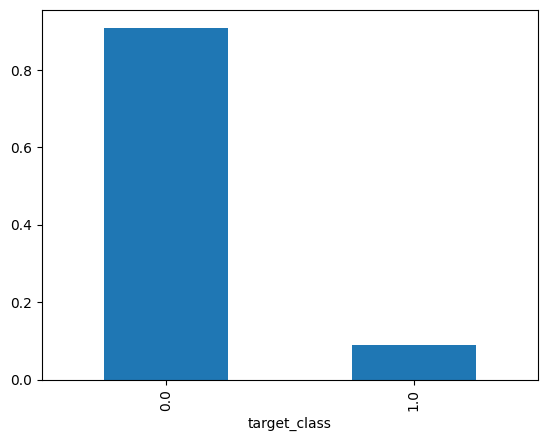

In [8]:
y_train['target_class'].value_counts(normalize=True).plot(kind='bar')
plt.show()

# 1.4 Plot the box plots

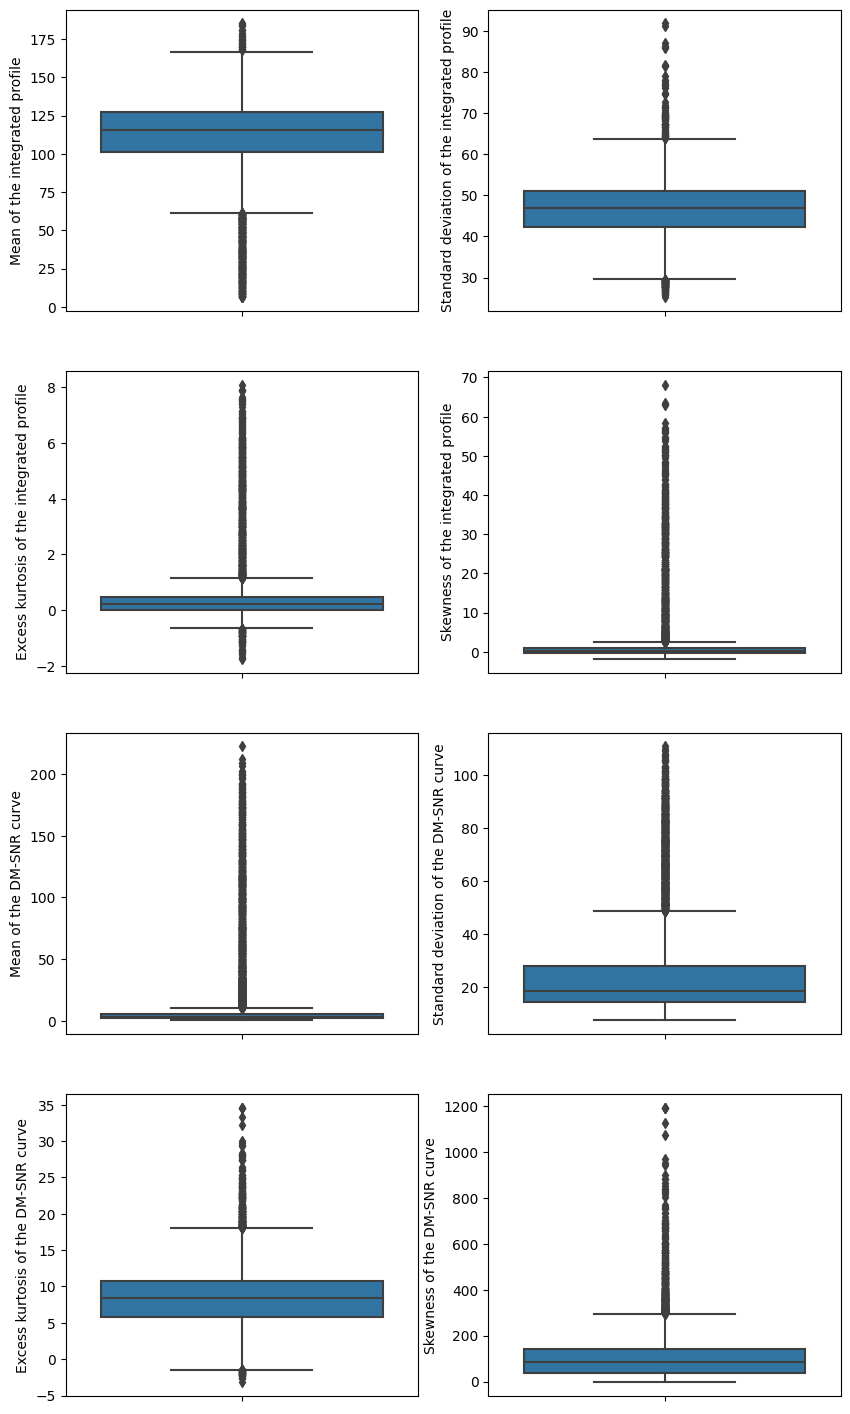

In [9]:
f, axes = plt.subplots(4, 2, figsize=(10, 18))

for i in range(0, 8, 2):
    sns.boxplot(y=X_train[feature_columns[i]], ax=axes[i//2][0],)
    sns.boxplot(y=X_train[feature_columns[i+1]], ax=axes[i//2][1])

plt.show()

**Note:** There are few columns with lot of outliers in it which are `Mean of the DM-SNR curve`, `Skewness of the integrated profile`  and `Excess kurtosis of the integrated profile`

# 1.5 Replace null values with `medain` of the columns

* Why median and not mean or mode?

Replacing missing values with the median, or median imputation, helps preserve the overall distribution of data, which keeps the dataset's general pattern and characteristics intact


In [10]:
from sklearn.impute import SimpleImputer

In [11]:
simple_imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(simple_imputer.fit_transform(X_train), columns=feature_columns)

# 2.0 Train SVM model


SVM has two types of classifiers:
1. Hard Margin Classifier: which doesn't allow any misclassifications or outliers
2. Soft Margin Classifer: which will allow some outlier with certain penality.

Import Aspects of SVM:

1. **In Scikit-Learn’s SVM classes, you can control this balance using the `C` hyperparameter: a smaller `C` value leads to a wider street but more margin violations.**

2. If your SVM model is overfitting, you can try regularizing it by reducing `C`.

3. You could use the SVC class, using `SVC(kernel="linear", C=1)`, but it is much slower, especially with large training sets, so it is not recommended. Another option is to use the SGDClassifier class, with `SGDClassifier(loss="hinge", alpha=1/(m*C))`. This applies regular Stochastic Gradient Descent to train a linear SVM classifier.


Sharp Bits:
1. The `LinearSVC` class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the `StandardScaler`.




# 2.1 Extensive Proof


Our main idea here is we have two separate classes using a hyperplane/plane/line so the basic need is we need margins that separate the data as far as the can strecth.Now use these boundaries to make prediction on new samples on which side of the margin lines the new sample fall into. Here $w^{T}x$ is basically projecting the new sample vector on to weight vector which will tell us the where the new sample fall into which side of the margin.

$$\vec{w}.\vec{u} + b \geq 0 \quad \mbox{then we say} + sample$$


Now strictly speaking if we have `+ve` sample and a `-ve` sample and substitute in the quation we can combine into a single equation as follows:


$$\vec{w}.\vec{x_{+}} + b \geq 1 \quad y_{i} = +1 \quad \mbox{for} +ve \; \mbox{samples} \rightarrow 1$$

$$\vec{w}.\vec{x_{-}} + b \leq -1 \quad y_{i} = -1 \quad \mbox{for} -ve \; \mbox{samples} \rightarrow 2$$


Now we can common for both of equation by introducing $y_{i}$ in the equation and when $y_{i}$ is $1$ it will be *equation 1* and if $y_{i}$ is $-1$ then it will be *euqation 2* from above:

<div class="alert alert-info">$$ y_{i}(w^{T}x_{i} + b) \geq 1 \quad \mbox{for both} \; +ve \; \mbox{and} \; -ve \; \mbox{samples}$$</div>


We have to maximise the distance between the margins of samples which can be done using the samples that lies close to the margins. Width of the street is basically difference between positive and negative vectors samples that lies on the boundary.

<center><img src="https://www.researchgate.net/publication/304611323/figure/fig8/AS:668377215406089@1536364954428/Classification-of-data-by-support-vector-machine-SVM.png"/></center>


**The equation comes as we project the difference of the vector on to the weight vector which is perpendicular to the margins. Here we just the magnitude of the width so we just take the dot product of the difference vector and the weight vector.**

$$\mathcal{width} = (\vec{x_{+}} - \vec{x_{-}}).\frac{\vec{w}}{||w||}$$

Let's now calculate how can we tackle the $x_{+}$ and $x_{-}$ which can be taken from before derived *decision rule*.

$$
+1*(\vec{x_{i}}.\vec{w} + b) - 1 = 0 \\
\vec{x_{i}}.\vec{w} = 1 - b
$$

$$
-1*(\vec{x_{i}}.\vec{w} + b - 1 = 0 \\
\vec{x_{i}}.\vec{w} = -(1 + b)
$$

Let's substite the above euqations now:

$$
\mathcal{width} = \frac{(\vec{x}_{+}.\vec{w} - \vec{x}_{-}.\vec{w})}{||\vec{w}||}\\
\mathcal{width} = \frac{(1-b) - (-(1+b))}{\vec{||w||}}\\
\mathcal{width} = \frac{2}{\vec{||w||}}
$$

Finally we have width equation in terms of weight vector which we try to maximize or else we can say minimize just the reciprocal of the below equation

$$\mathcal{width} = \frac{2}{\vec{||w||}} \rightarrow \mathcal{maximize}$$

$$\mathcal{width} = \frac{\vec{||w||}}{2}  \rightarrow \mathcal{minimize}$$

To make differentiation Easy:   <div class="alert alert-success">$$\mathcal{width} = \frac{1}{2}\frac{\vec{||w||^{2}}}{2}  \rightarrow \mathcal{minimize}$$</div>


But here we have constraints on these equations which is not regular from our linear regression optimizations. So we use [`Langrange's Multipliers`](https://en.wikipedia.org/wiki/Lagrange_multiplier) which I also have very less idea 🫠. Just from little research what I found is that, it is used when we have constraints on euqations and it can be helpful to optimize these cases. `Langrange's Multipliers` will make us not dependent on constraints.


$$ L = \frac{1}{2}||\vec{w}^{2}|| - \sum\alpha_{i}\left[y_{i}(\vec{w}.x_{i}+b)-1\right] $$

Finally we have a equation as below and if see the carefully it depends on the dot products of the two vectors of the data itself. Dual problem:
$$ $$
$$ \underset{\alpha}{\text{minimize}} \quad \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha_i \alpha_j t_i t_j \mathbf{x}_i^T \mathbf{x}_j - \sum_{i=1}^{m} \alpha_i \\
\text{subject to} \quad \alpha_i \geq 0 \quad \text{for} \quad i = 1, 2, \cdots, m
$$




# 2.2 Kernel Trick

* When we want increase the complexity the of features by adding polynomial/increase degrees of features, the no.of features increase exponentially which makes the model to slow.
* Fortunately, when using SVM's you can apply a mathematical technique called the *kernel trick*. It makes it possible to get the same results as if you add any prolynomial features.

Common Kernels:

*Linear Kernel : $$ K(a,b) = a^{T}b$$*

*Polynomial Kernel: $$ K(a, b) = \left( \gamma a^{T}b + r\right)^{d}$$*

*Gaussian RBF: $$K(a,b) = \exp(-\gamma||a-b||^{2})$$*

*Sigmoid: $$K(a,b) = tanh(\gamma a^{T}b + r)$$*

What happens in kernel trick is for example when we transform the two vectors two dimensional and multiply them results is basically dot product of one dimensional vectors power:

$$\phi(a)^{T}\phi(b) = \begin{pmatrix}( a_{1}^{2} \\ \sqrt{2}a_{1}a_{2} \\ a_{2}^{2}\end{pmatrix} \begin{pmatrix}( b_{1}^{2} \\ \sqrt{2}b_{1}b_{2} \\ b_{2}^{2}\end{pmatrix} = a_{1}^{2}b_{1}^{2} + 2a_{1}b_{1}a_{2}b_{2} + a_{2}^{2}b_{2}^{2}$$

$$= (a_{1}b_{1} + a_{2}b_{2})^{2} = \begin{pmatrix}\begin{pmatrix}a_{1} \\ a_{2}\end{pmatrix}^{T} \begin{pmatrix}b_{1} \\ b_{2}\end{pmatrix}\end{pmatrix}^{2} = (a^{T}b)^{2}$$


**How about that? The dot product of the transformed vectors is equal to the square of
the dot product of the original vectors: $\phi(a)^{T}\phi(b) = (a^{T}b)^{2}$**


Now here is the key insight: if you apply the transformation $\phi$ to all training instances,
then the dual problem (see Equation 5-6) will contain the dot product $\phi(X^{(i)})^{T}\phi(X^{(j)})$. But if $\phi$ is the $2^{nd}$-degree polynomial transformation defined in above equation then you can replace this dot product of transformed vectors simply by $((x^{(i)})^{T}x^{(j)})^{2}$.So you don’t actually need to transform the training instances at all: just replace the dot product by its square in the equation.

# 2.3 Fit SVM using linear kernel

In [12]:
linear_kernel_svm_clf = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="linear", gamma=5, C=0.001))
    ]
)
linear_kernel_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5, kernel='linear'))])

# 2.4 Try cross validation and train dataset

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict, cross_val_score

skfolds = StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)

In [14]:
acc = []
for idx, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train)):
    clone_clf = clone(linear_kernel_svm_clf)
    X_train_folds = X_train.iloc[train_index, :]
    y_train_folds = y_train.iloc[train_index, :]
    X_test_folds = X_train.iloc[test_index, :]
    y_test_folds = y_train.iloc[test_index, :]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds.values[:, 0])
    acc.append(n_correct / len(y_pred))
    print(f"Accuracy for fold {idx+1}: {n_correct / len(y_pred)}")

print(f"Average Cross Validation Accuracies: {np.mean(acc)}")

Accuracy for fold 1: 0.9658784794971566
Accuracy for fold 2: 0.9625860520802155
Accuracy for fold 3: 0.9658682634730539
Average Cross Validation Accuracies: 0.964777598350142


In [15]:
print(f"Cross validation same as above but from sklearn: {np.mean(cross_val_score(linear_kernel_svm_clf, X_train, y_train, cv=3))}")

Cross validation same as above but from sklearn: 0.9649774381198691


# 3.0 Hyperparameter Optimization using GridSearch CV

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
svc = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm_clf", SVC())
    ]
)


# Let's declare hyperparameters for each possible argument in svc
param_grid = [ 
    {
        'svm_clf__C': [1, 10, 100, 1000], 
        'svm_clf__kernel':['linear']
    },
    {
        'svm_clf__C': [1, 10, 100, 1000], 
        'svm_clf__kernel': ['rbf'], 
        'svm_clf__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    },
    {
        'svm_clf__C':[1, 10, 100, 1000], 
        'svm_clf__kernel':['poly'], 
        'svm_clf__degree': [2, 3, 4] ,
        'svm_clf__gamma':[0.01, 0.02, 0.03, 0.04, 0.05]
    } 
]

grid_svc = GridSearchCV(
    svc,
    param_grid,
    scoring="accuracy",
    return_train_score=True,
    cv=5
)

grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm_clf', SVC())]),
             param_grid=[{'svm_clf__C': [1, 10, 100, 1000],
                          'svm_clf__kernel': ['linear']},
                         {'svm_clf__C': [1, 10, 100, 1000],
                          'svm_clf__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                             0.8, 0.9],
                          'svm_clf__kernel': ['rbf']},
                         {'svm_clf__C': [1, 10, 100, 1000],
                          'svm_clf__degree': [2, 3, 4],
                          'svm_clf__gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'svm_clf__kernel': ['poly']}],
             return_train_score=True, scoring='accuracy')

# 3.1 Check for Best Paramaters Now and train the model on Train Dataset

In [18]:
print(f"Best Accuracy from all the model variations: {grid_svc.best_score_}")

print(f"Best Hyperaparameters from all different hyperparameters give: {grid_svc.best_params_}")

Best Accuracy from all the model variations: 0.9785471451112737
Best Hyperaparameters from all different hyperparameters give: {'svm_clf__C': 10, 'svm_clf__gamma': 0.1, 'svm_clf__kernel': 'rbf'}


In [19]:
best_params = grid_svc.best_params_

pipe_svc = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm_clf", SVC())
    ]
)

pipe_svc.set_params(**best_params)

pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=10, gamma=0.1))])

# 3.2 Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B.

| | Predicted Condition | | | |
| --- | --- | --- | --- | --- |
| | **Positive (PP)**| **Negative (PN)**</div> | **Total Population** | **Equation** |
| **Actual Condition Positive (P)** | <div class="alert alert-success">True Positive (TP)</div> | <div class="alert alert-danger">False Negative (FN)</div> | P | <div class="alert alert-info">Recall/TPR = $\frac{TP}{TP + FN}$ |
| **Actual Condition Negative (N)**</div> | <div class="alert alert-danger">False Positive (FP)</div> | <div class="alert alert-success">True Negative (TN)</div> | N | <div class="alert alert-info">Specificity = $\frac{TN}{FP + TN}$ |
| **Total Predicted Condition** | PP | PN | P + N | |
| **Equation** | <div class="alert alert-info">Precision = $\frac{TP}{TP + FP}$ | <div class="alert alert-info">NPV = $\frac{TN}{TN + FN}$ | | |


<div class="alert alert-success">
<h8>TP (True Positive)</h8>
These are the instances that were correctly predicted as positive by the model.
</div>

<div class="alert alert-danger">
<h8>FP (False Positive)</h8>
These are the instances that were incorrectly predicted as positive by the model, but their true label is negative.
</div>

<div class="alert alert-success">
<h8>TN (True Negative)</h8>
These are the instances that were correctly predicted as negative by the model.
</div>

<div class="alert alert-danger">
<h8>FN (False Negative)</h8>
These are the instances that were incorrectly predicted as negative by the model, but their true label is positive.
</div>


In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
X_val = simple_imputer.transform(X_val)

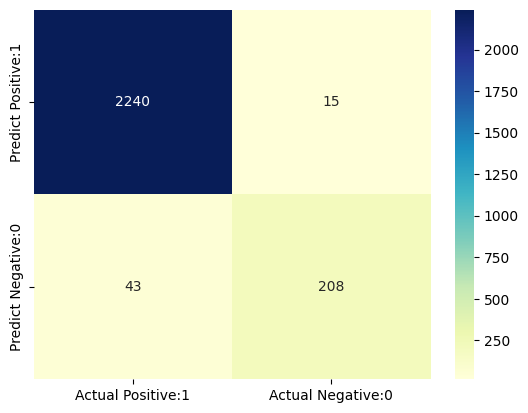

In [22]:
y_predict = pipe_svc.predict(X_val)

cm = confusion_matrix(y_val, y_predict)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

# 3.3 Classification Report

In [23]:
from sklearn.metrics import classification_report

y_val_pred = pipe_svc.predict(X_val)


print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2255
         1.0       0.93      0.83      0.88       251

    accuracy                           0.98      2506
   macro avg       0.96      0.91      0.93      2506
weighted avg       0.98      0.98      0.98      2506



# 3.4 Precision Recall Curve


The figure below demonstrates how some theoretical classifiers would plot on a precision-recall curve. 

**The gray dotted line represents a “baseline” classifier — this classifier would simply predict that all instances belong to the positive class.**

**The purple line represents an ideal classifier — one with perfect precision and recall at all thresholds. Nearly all real-world examples will fall somewhere between these two lines — not perfect, but providing better predictions than the “baseline”.**

**A good classifier will maintain both a high precision and high recall across the graph, and will “hug” the upper right corner in the figure below.**



<center><img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*6QPLsDvjo4H6OZrxEBI8Fg.png" width="500" height="600"></center>


In [24]:
import sklearn.metrics as skm

## 3.4.1 We use decision function here as we need scores to divide at different thresholds and as per SVM we will have positive or negative class based on the if `samples >=1` or `samples <= -1 `

In [25]:
y_predict = pipe_svc.decision_function(X_val) 
precisions, recalls, thresholds = skm.precision_recall_curve(y_val, y_predict)

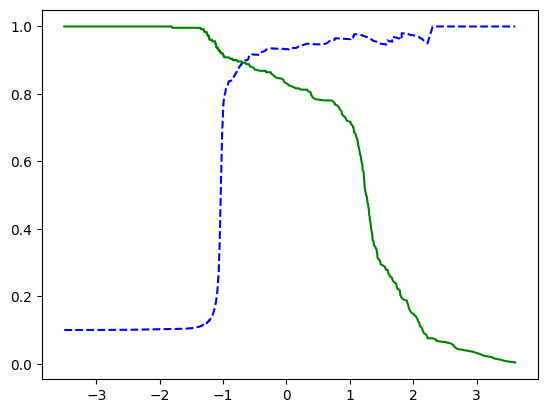

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
from sklearn.metrics import PrecisionRecallDisplay

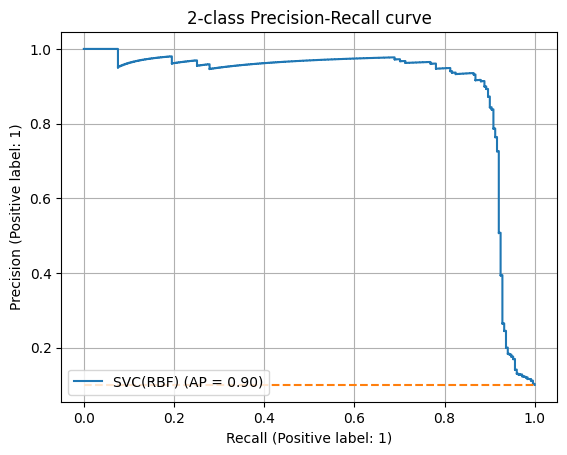

In [28]:
y_scores = pipe_svc.decision_function(X_val)
baseline = len(y_val[y_val['target_class'] == 1.0]) / len(y_val)

display = PrecisionRecallDisplay.from_predictions(
    y_val, y_scores, name="SVC(RBF)",
)

plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.grid()

_ = display.ax_.set_title("2-class Precision-Recall curve")

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_val_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
skm.precision_score(y_val, y_val_pred_90)

0.902834008097166

In [31]:
skm.recall_score(y_val, y_val_pred_90)

0.8884462151394422

# 3.5 AUC-PR and AP

 
**AUC-PR** is a metric that summarizes the overall performance of a classification model based on the PRC. It essentially calculates the area under the Precision-Recall Curve.

**Interpretation:** An AUC-PR of 1 represents a perfect classifier, where the model perfectly separates positive and negative samples at all thresholds.An AUC-PR of 0.5 indicates a random classifier, where the model performs no better than chance in distinguishing between classes.
Values closer to 1 are generally better, indicating the model can distinguish classes well across different thresholds.


**Average Precision (AP)** is another metric that summarizes the performance of a classification model based on the PRC. It represents the average of the precision values achieved at each threshold where a sample is classified as positive.

**Interpretation:** Similar to AUC-PR, a higher AP value indicates better performance. It signifies that the model achieves high precision consistently across different classification thresholds where it recalls positive samples.


In [32]:
print(f"AUC-PR Score: {skm.auc(recalls, precisions)}")
print(f"AP Score:{skm.average_precision_score(y_val, y_scores)}")

AUC-PR Score: 0.8984935139645254
AP Score:0.8986983133554993


*Note: Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise.*

# 3.6 Reciever Operating Characteristics (ROC) & AUC-ROC

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate

The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots `sensitivity (recall)` versus
`1 – specificity`


AUC is desirable for the following two reasons:

* AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

* Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

* Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.






In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_scores)

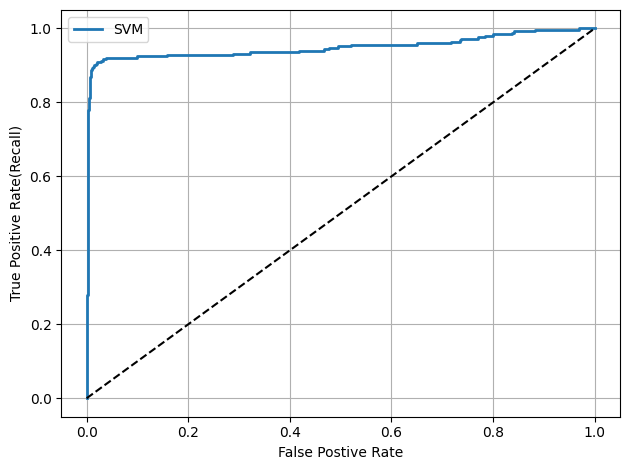

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    
plot_roc_curve(fpr, tpr, label="SVM")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

<div class="alert alert-info">
One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.
</div>

In [35]:
skm.roc_auc_score(y_val, y_scores)

0.9497795955866115

# 3.7 ROC vs PR-Curve


The ROC curve is plotted using the true positive rate (TPR) and false positive rate (FPR) at various thresholds, but the thresholds themselves are determined by the model's scores or predicted probabilities. The ROC curve does not depend on any specific threshold chosen by the user or analyst. It shows the trade-off between TPR and FPR across all possible thresholds, making it independent of the chosen threshold.

On the other hand, the PR curve is plotted using precision and recall values, which are calculated based on the specific classification threshold used to convert the model's scores or probabilities into binary predictions. The PR curve is sensitive to the chosen threshold, as different thresholds will result in different precision and recall values.

This difference in how the two curves are constructed leads to their suitability for different use cases:

1. **ROC curve is more helpful when:**
   - You want to evaluate the overall ranking or separation ability of the model, regardless of the specific classification threshold.
   - The classes are relatively balanced, and you're interested in the trade-off between true positive rate and false positive rate.
   - You need a threshold-independent evaluation metric, like the Area Under the ROC Curve (AUC-ROC).

2. **PR curve is more helpful when:**
   - You are dealing with highly imbalanced datasets, where one class (e.g., positive class) is rare or of particular interest.
   - You care more about the trade-off between precision and recall, rather than the true positive rate and false positive rate.
   - You need to choose an appropriate classification threshold based on the desired balance between precision and recall for your specific application.
   - The positive class is more important, and you want to prioritize either high precision (fewer false positives) or high recall (fewer false negatives).

In summary, the ROC curve is a more general evaluation metric that provides an overall assessment of the model's ranking performance, while the PR curve is particularly useful when dealing with imbalanced datasets and when the focus is on the positive class or a specific operating point defined by the classification threshold.

Both curves are valuable tools for evaluating binary classification models, and the choice between them depends on the specific problem, data characteristics, and the evaluation criteria that are most relevant to the application.


<div class="alert alert-info">
Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.
</div>

# 4.0 References:

1. [MIT Video](https://www.youtube.com/watch?v=_PwhiWxHK8o&ab_channel=MITOpenCourseWare)
2. [2-Aurélien-Géron-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow_-Concepts-Tools-and-Techniques-to-Build-Intelligent-Systems-O’Reilly-Media-2019](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
3. [SVM Tutorial](https://www.kaggle.com/code/prashant111/svm-classifier-tutorial#18.-ROC---AUC-)
4. [Precision and Recall](https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248)
5. [SVM Research Gate Image](https://www.researchgate.net/figure/Classification-of-data-by-support-vector-machine-SVM_fig8_304611323)
6. [ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)